<a href="https://colab.research.google.com/github/iwatsuki-yuuki/AI-matuso/blob/main/reddit%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reddit分析ツール

In [98]:
!pip install -q praw openai transformers torch pandas matplotlib wordcloud

In [9]:
# googlecolobを公開用にAPIのキーを伏せる
import os, getpass

print("▼ OpenAI API key を入力してください")
os.environ["OPENAI_API_KEY"] = getpass.getpass()

print("▼ Reddit client_id を入力してください")
os.environ["REDDIT_CLIENT_ID"] = getpass.getpass()

print("▼ Reddit client_secret を入力してください")
os.environ["REDDIT_CLIENT_SECRET"] = getpass.getpass()

# 任意の user_agent（推奨: 説明的な文字列）
os.environ["REDDIT_USER_AGENT"] = "reddit-sentiment-bot/0.2 by u/SheepherderOnly9123"

print("設定完了")

▼ OpenAI API key を入力してください
··········
▼ Reddit client_id を入力してください
··········
▼ Reddit client_secret を入力してください
··········
✅ キーを環境変数に設定しました（ノート上には残りません）


In [99]:
# 接続テスト（redditがうまく繋がってるか）
!pip install -q praw

import praw
reddit = praw.Reddit(
    client_id     = os.getenv("REDDIT_CLIENT_ID"),
    client_secret = os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent    = os.getenv("REDDIT_USER_AGENT")
)

# technologyについての情報を取得
for post in reddit.subreddit("technology").hot(limit=3):
    print("•", post.title)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



• ‘The vehicle suddenly accelerated with our baby in it’: the terrifying truth about why Tesla’s cars keep crashing | Tesla
• Schools turn to handwritten exams as AI cheating surges
• Samsung delays $44 billion Texas chip fab — sources say completion halted because 'there are no customers'


In [100]:
# 感情分析するモデルを読み込む
# huggingfaceにあったmodelを使った
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, numpy as np

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # 汎用モデル
tok   = AutoTokenizer.from_pretrained(MODEL)
mdl   = AutoModelForSequenceClassification.from_pretrained(MODEL)
labels = ["negative", "neutral", "positive"]

def hf_sentiment(text):
    inputs = tok(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        probs = torch.softmax(mdl(**inputs).logits, dim=-1)[0].numpy()
    return labels[int(np.argmax(probs))], float(np.max(probs))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
# RedditAPIのPRAWを使い、指定したsubredditからキーワード検索した投稿タイトルとタイムスタンプをDataFrameにまとめて返す関数
import praw, pandas as pd

reddit = praw.Reddit(
    client_id     = os.getenv("REDDIT_CLIENT_ID"),
    client_secret = os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent    = os.getenv("REDDIT_USER_AGENT")
)

def fetch_reddit_titles(subreddit="technology", query="AI", limit=30):
    posts = reddit.subreddit(subreddit).search(query, limit=limit, sort="new")
    rows  = [[p.created_utc, p.title] for p in posts]
    return pd.DataFrame(rows, columns=["Time", "Title"])

In [102]:
# sentimentの列をdfに追加（感情列で3分類）
df = fetch_reddit_titles("technology", "AI", limit=20)
df[["Sentiment", "Score"]] = df["Title"].apply(lambda t: pd.Series(hf_sentiment(t)))
df.head()

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



,Time,Title,Sentiment,Score
0,1.751727e+09,Schools turn to handwritten exams as AI cheati...,negative,0.668340
1,1.751727e+09,New research warns against trusting AI for mor...,negative,0.791684
2,1.751722e+09,EU says it will continue rolling out AI legisl...,neutral,0.822678
3,1.751668e+09,Ted Cruz’s Dumb Plan To Punish States That Reg...,negative,0.822739
4,1.751662e+09,Anthropic destroyed millions of print books to...,negative,0.747580


In [103]:
# gptを最新版にする
!pip install -q --upgrade openai

In [104]:
from openai import OpenAI
client = OpenAI()

In [107]:
!pip install -q nltk scikit-learn

import nltk, re, string, pandas as pd, numpy as np
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from IPython.display import Markdown, display
from openai import OpenAI

nltk.download("stopwords", quiet=True)
stop_en = set(nltk.corpus.stopwords.words("english")) | set(ENGLISH_STOP_WORDS)
punct_tbl = str.maketrans("", "", string.punctuation)
client = OpenAI()

def analyze_and_visualize(sub, query, n=30, do_summary=True):
    # Reddit取得
    df = fetch_reddit_titles(sub, query, n)

    # センチメント推定
    df[["Sentiment", "Score"]] = df["Title"].apply(
        lambda t: pd.Series(hf_sentiment(t))
    )
    # GPT要約
    if do_summary:
        df["Summary"] = df["Title"].apply(gpt_summary)

    # 棒グラフ
    plt.figure(figsize=(5,3))
    df["Sentiment"].value_counts().reindex(labels).fillna(0).plot(
        kind="bar", color=["salmon", "lightgray", "skyblue"]
    )
    plt.title("Sentiment Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # ワードクラウド
    wc_text = " ".join(df["Title"])
    wc = WordCloud(width=700, height=400, background_color="white").generate(wc_text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

    return df

def gpt_summary(text, max_chars=60):
    prompt = (
        f"次の Reddit 投稿タイトルを **日本語** で "
        f"{max_chars}文字以内に要約してください。\n\n{text}"
    )
    res = client.chat.completions.create(
        model="gpt-3.5-turbo",       # GPT-4 でも可
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=120
    )
    return res.choices[0].message.content.strip()

def simple_keywords(titles, top_n=10):
    words = []
    for t in titles:
        tokens = re.sub(r"http\S+|[^A-Za-z']+", " ", t).lower().split()
        words.extend([w for w in tokens if w not in stop_en and len(w) > 2])
    return Counter(words).most_common(top_n)

def gpt_overall_summary(titles, max_chars=999):
    joined_titles = " / ".join(titles)

    prompt = (
        "あなたはSNS分析レポート作成AIです。以下の Reddit 投稿一覧を読み取り、"
        "検索キーワードそのもの（例: AI, technology 等）には触れずに、"
        "次の日本語テンプレート形式でまとめてください。\n"
        "【テンプレート】\n"
        "〇〇、〇〇…などの投稿について検索し、総じて〇〇のような意見や〇〇のような意見が多くありました。"
        "また特に〇〇に関する内容が多かったです。\n"
        "※テンプレート中の〇〇には “具体的な話題 or 意見” を入れてください。\n\n"
        "【投稿一覧】\n"
        f"{joined_titles}"
    )

    res = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=999
    )
    return res.choices[0].message.content.strip()

def analyze_with_report(sub="technology", query="AI", n=100, do_summary=True):

    df = analyze_and_visualize(sub, query, n, do_summary)


    counts = df["Sentiment"].value_counts().reindex(labels).fillna(0).astype(int)
    kw_top = simple_keywords(df["Title"], 10)
    overall = gpt_overall_summary(df["Title"].tolist(), 150)

    # ③ Markdown レポート
    report_lines = [
        f"### ✨ Reddit `{sub}` × **{query}** 全体総評（{n}件）",
        f"> **{overall}**",
        "",
        "#### ■ センチメント分布",
        *(f"- **{k.capitalize()}**: {v}件" for k, v in counts.items()),
        "",
        "#### ■ キーワード TOP10",
        *(f"- {w}: {c}回" for w, c in kw_top),
    ]
    if "Summary" in df:
        samples = df["Summary"].head(10).tolist()       # ← 3 ➜ 10 件
        report_lines += [
            "",
            "#### ■ 要約サンプル（10件）",              # ← タイトルも合わせる
            *(f"- {s}" for s in samples)
        ]

    display(Markdown("\n".join(report_lines)))
    return df

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



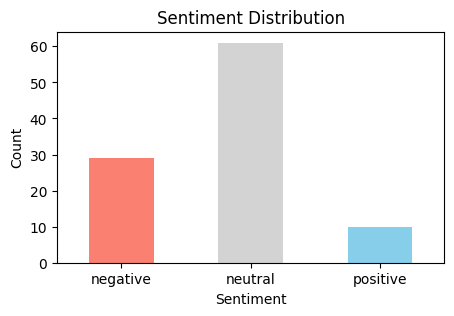

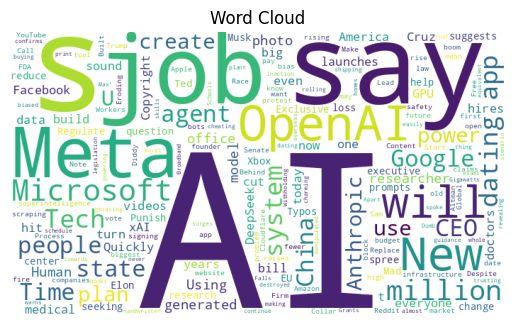

### ✨ Reddit `technology` × **AI** 全体総評（100件）
> **Redditの投稿を読み取りました。AIに関する投稿が多かったです。具体的には、学校がAIの不正利用に対抗して手書きの試験を導入したり、AIが倫理的な指針として信頼されないことを警告する研究が行われたり、AIが求められる規制をEUが進めると発表したり、AIが電話センターの問題を増やすという声がありました。また、AIが医療ケアを求める人々を妨げる可能性があるという話題もありました。AIに関する様々な意見や懸念がRedditで議論されているようです。**

#### ■ センチメント分布
- **Negative**: 29件
- **Neutral**: 61件
- **Positive**: 10件

#### ■ キーワード TOP10
- says: 14回
- openai: 11回
- new: 10回
- meta: 10回
- dating: 7回
- microsoft: 7回
- jobs: 6回
- tech: 6回
- people: 5回
- job: 5回

#### ■ 要約サンプル（10件）
- AIの不正行為が増加する中、学校が手書き試験に切り替え
- AIに道徳的な指針を信頼すべきでないという新しい研究。システムは行動を取らない傾向があり、質問の言い回しで簡単に操作される可能性がある。
- EUはAI関連の法制度を予定通り展開すると発表
- テッド・クルーズの愚かな計画：AI規制をする州にブロードバンド補助金を拒否する案が破綻
- AIモデル構築のためにAnthropic社が何百万冊もの印刷本を破壊
- デートアプリでAIが魅力的に会話を作成している。
- イーロン・マスクがxAIが海外の発電所を購入し、新しいデータセンターの電力源として米国に輸送することを確認
- AIが「マッドマックス」のような状況を作り出す可能性がある、と経済学者が警告
- Xbox幹部がAIを使って解雇の痛みを和らげることを提案
- AIが医療ケアを探すことを desuasu するために、タイプミスや俗語が使われています。

In [108]:
# 引数はtechnologyとAIにして投稿数は100個から検索
result_df = analyze_with_report("technology", "AI", n=100, do_summary=True)

# Streamlit公開用コード

In [94]:
# --- Step 1: LT を完全 BG 起動（セルはすぐ終わる）---
%%bash --bg
npx localtunnel --port 8501 --subdomain reddit-sentiment > /tmp/lt.log 2>&1

In [95]:
%%writefile app.py
import os, re, string, pandas as pd, numpy as np, nltk, matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import praw, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from openai import OpenAI
import streamlit as st


nltk.download("stopwords", quiet=True)
stop_en = set(nltk.corpus.stopwords.words("english")) | set(ENGLISH_STOP_WORDS)
labels  = ["negative","neutral","positive"]

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tok   = AutoTokenizer.from_pretrained(MODEL)
mdl   = AutoModelForSequenceClassification.from_pretrained(MODEL)
client = OpenAI()
reddit = praw.Reddit(
    client_id     = os.getenv("REDDIT_CLIENT_ID"),
    client_secret = os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent    = os.getenv("REDDIT_USER_AGENT")
)


def hf_sentiment(text):
    inputs = tok(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        logits = mdl(**inputs).logits
        probs  = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    return labels[int(probs.argmax())]

def hf_sentiment(text):
    inputs = tok(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        probs = torch.softmax(mdl(**inputs).logits, dim=-1)[0].numpy()
    return labels[int(np.argmax(probs))]

def gpt_summary(text, max_chars=60):
    prompt = f"次のReddit投稿タイトルを日本語で{max_chars}文字以内に要約してください。\n\n{text}"
    res = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role":"user","content":prompt}],
        temperature=0.3, max_tokens=120
    )
    return res.choices[0].message.content.strip()

def gpt_overall(titles):
    joined = " / ".join(titles)
    prompt = (
        "あなたはSNS分析レポート作成AIです。以下のReddit投稿一覧を読み取り、"
        "検索語そのものには触れずに、"
        "＊〇〇、〇〇…などの投稿が多く見られ、総じて〇〇のような意見や〇〇のような意見が多くありました。"
        "また特に〇〇に関する内容が多かったです。"
        "という日本語テンプレートでまとめてください。\n\n" + joined
    )
    res = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role":"user","content":prompt}],
        temperature=0.3, max_tokens=999
    )
    return res.choices[0].message.content.strip()

def simple_kw(titles, top_n=10):
    words=[]
    for t in titles:
        tokens = re.sub(r"http\S+|[^A-Za-z']+"," ",t).lower().split()
        words += [w for w in tokens if w not in stop_en and len(w)>2]
    return Counter(words).most_common(top_n)

# streamlitのUIについて
st.title("📊 Reddit Sentiment Analyzer")

sub = st.text_input("Subreddit（コミュニティ）")
qry = st.text_input("検索キーワード")
n   = st.slider("取得件数", 20, 150, 50)
run = st.button("分析する")

if run:
    with st.spinner("Reddit 取得…"):
        posts = reddit.subreddit(sub).search(qry, limit=n, sort="new")
        df = pd.DataFrame([[p.created_utc, p.title] for p in posts], columns=["Time","Title"])

    st.write(f"取得件数: {len(df)} 件")

    with st.spinner("感情分析…"):
        df["Sentiment"] = df["Title"].apply(hf_sentiment)

    with st.spinner("GPT 要約中…"):
        df["Summary"] = df["Title"].apply(gpt_summary)

    st.subheader("📝 総評")
    st.success(gpt_overall(df["Title"].tolist()))

    st.subheader("📊 センチメント分布")
    st.bar_chart(df["Sentiment"].value_counts().reindex(labels).fillna(0))

    st.subheader("☁️ WordCloud")
    wc = WordCloud(width=700,height=400,background_color="white").generate(" ".join(df["Title"]))
    st.image(wc.to_array())

    st.subheader("📋 要約サンプル（10件）")
    for s in df["Summary"].head(10):
        st.markdown(f"- {s}")

    st.subheader("🗂️ データフレーム")
    st.dataframe(df)

Overwriting app.py


In [96]:
!streamlit run app.py --server.port 8501 &>/dev/null &

In [97]:
!tail -f /tmp/lt.log

your url is: https://reddit-sentiment.loca.lt
^C


In [92]:
!curl -s ifconfig.me

104.198.219.185